## IE590 Project Experiment - 2

### Experiment-2 involves training a Spiking Neural Network using 3 evolutionary algorithms which include Real Coded GA, Differential Evolution and Particle Swarm Optimizer. Results from all these algorithms are combined by majority voting to investigate any improvement in results


### Tensor Flow Functions pertaining to Spiking Neural Networks have been obtained from this source : 

### https://github.com/kaizouman/tensorsandbox/blob/master/snn/STDP_masquelier_2008.ipynb

### Functions have been modified to conduct the experiments

 ### Importing Libraries in Python

In [ ]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import math
import random as r
import time
import statistics
%matplotlib inline

### Leaky Integrate and Fire Neuron

In [ ]:
class LIFNeuron(object):
    
    def __init__(self, u_rest=0.0, u_thresh=1.0, tau_rest=4.0, r=1.0, tau=10.0):
        
        # Membrane resting potential in mV
        self.u_rest = u_rest
        # Membrane threshold potential in mV
        self.u_thresh = u_thresh
        # Duration of the resting period in ms
        self.tau_rest = tau_rest
        # Membrane resistance in Ohm
        self.r = r
        # Membrane time constant in ms
        self.tau = tau
        
        # Instantiate a graph for this neuron
        self.graph = tf.Graph()
        
        # Build the graph
        with self.graph.as_default():
        
            # Variables and placeholders
            self.get_vars_and_ph()
            
            # Operations
            self.input = self.get_input_op()
            self.potential = self.get_potential_op()
            # Note that input is a prerequisite of potential, so it will
            # always be evaluated when potential is
            
    # Variables and placeholders
    def get_vars_and_ph(self):

        # The current membrane potential
        self.u = tf.Variable(self.u_rest, dtype=tf.float32, name='u')
        # The duration left in the resting period (0 most of the time except after a neuron spike)
        self.t_rest = tf.Variable(0.0, dtype=tf.float32, name='t_rest')
        # Input current
        self.i_app = tf.placeholder(dtype=tf.float32, name='i_app')
        # The chosen time interval for the stimulation in ms
        self.dt = tf.placeholder(dtype=tf.float32, name='dt')

    # Evaluate input current
    def get_input_op(self):
        
        return self.i_app
        
    # Neuron behaviour during integration phase (below threshold)
    def get_integrating_op(self):

        # Get input current
        i_op = self.get_input_op()

        # Update membrane potential
        du_op = tf.divide(tf.subtract(tf.multiply(self.r, i_op), self.u), self.tau) 
        u_op = self.u.assign_add(du_op * self.dt)
        # Refractory period is 0
        t_rest_op = self.t_rest.assign(0.0)
        
        return u_op, t_rest_op

    # Neuron behaviour during firing phase (above threshold)    
    def get_firing_op(self):                  

        # Reset membrane potential
        u_op = self.u.assign(self.u_rest)
        # Refractory period starts now
        t_rest_op = self.t_rest.assign(self.tau_rest)

        return u_op, t_rest_op

    # Neuron behaviour during resting phase (t_rest > 0)
    def get_resting_op(self):

        # Membrane potential stays at u_rest
        u_op = self.u.assign(self.u_rest)
        # Refractory period is decreased by dt
        t_rest_op = self.t_rest.assign_sub(self.dt)
        
        return u_op, t_rest_op

    def get_potential_op(self):
        
        return tf.case(
            [
                (self.t_rest > 0.0, self.get_resting_op),
                (self.u > self.u_thresh, self.get_firing_op),
            ],
            default=self.get_integrating_op
        )

### Leaky Integrate and Fire Neuron with Synaptic Inputs

In [ ]:
# It takes synaptic spikes as input and remember them over a specified time period
class LIFSynapticNeuron(LIFNeuron):
    
    def __init__(self, n_syn, w, max_spikes=50, u_rest=0.0, u_thresh=1.0, tau_rest=4.0, r=1.0, tau=10.0, q=1.5, tau_syn=5.0):
      
        # Number of synapses
        self.n_syn = n_syn
        # Maximum number of spikes we remember
        self.max_spikes = max_spikes
        # The neuron synaptic 'charge'
        self.q = q
        # The synaptic time constant (ms)
        self.tau_syn = tau_syn
        # The synaptic efficacy
        self.w = w

        super(LIFSynapticNeuron, self).__init__(u_rest, u_thresh, tau_rest, r, tau)
    
    # Update the parent graph variables and placeholders
    def get_vars_and_ph(self):
        
        # Get parent grah variables and placeholders
        super(LIFSynapticNeuron, self).get_vars_and_ph()

        # Add ours
        
        # The history of synaptic spike times for the neuron 
        self.t_spikes = tf.Variable(tf.constant(-1.0, shape=[self.max_spikes, self.n_syn], dtype=tf.float32))
        # The last index used to insert spike times
        self.t_spikes_idx = tf.Variable(self.max_spikes-1, dtype=tf.int32)
        # A placeholder indicating which synapse spiked in the last time step
        self.syn_has_spiked = tf.placeholder(shape=[self.n_syn], dtype=tf.bool)

    # Operation to update spike times
    def update_spike_times(self):
        
        # Increase the age of older spikes
        old_spikes_op = self.t_spikes.assign_add(tf.where(self.t_spikes >=0,
                                                          tf.constant(1.0, shape=[self.max_spikes, self.n_syn]) * self.dt,
                                                          tf.zeros([self.max_spikes, self.n_syn])))

        # Increment last spike index (modulo max_spikes)
        new_idx_op = self.t_spikes_idx.assign(tf.mod(self.t_spikes_idx + 1, self.max_spikes))

        # Create a list of coordinates to insert the new spikes
        idx_op = tf.constant(1, shape=[self.n_syn], dtype=tf.int32) * new_idx_op
        coord_op = tf.stack([idx_op, tf.range(self.n_syn)], axis=1)

        # Create a vector of new spike times (non-spikes are assigned a negative time)
        new_spikes_op = tf.where(self.syn_has_spiked,
                                 tf.constant(0.0, shape=[self.n_syn]),
                                 tf.constant(-1.0, shape=[self.n_syn]))
        
        # Replace older spikes by new ones
        return tf.scatter_nd_update(old_spikes_op, coord_op, new_spikes_op)

    # Override parent get_input_op method
    def get_input_op(self):
        
        # Update our memory of spike times with the new spikes
        t_spikes_op = self.update_spike_times()

        # Evaluate synaptic input current for each spike on each synapse
        i_syn_op = tf.where(t_spikes_op >=0,
                            self.q/self.tau_syn * tf.exp(tf.negative(t_spikes_op/self.tau_syn)),
                            t_spikes_op*0.0)

        # Add each synaptic current to the input current
        i_op =  tf.reduce_sum(self.w * i_syn_op)
        
        return tf.add(self.i_app, i_op)

### Spike Response Model with Synaptic Inputs

In [436]:
class LIFNeuron(object):

    def __init__(self,
                 n_syn, w, max_spikes=None, 
                 p_rest=0.0, tau_rest=1.0, tau_m=10.0, tau_s=2.5, T=None,
                 K=2.1, K1=2.0, K2=4.0):

        # Model parameters

        # Membrane resting potential
        self.p_rest = p_rest
        
        # Duration of the recovery period
        self.tau_rest = tau_rest
        
        # Membrane time constant
        self.tau_m = tau_m
        
        # Synaptic time constant
        self.tau_s = tau_s
        
        # Spiking threshold
        if T is None:
            self.T = n_syn/4
        else:
            self.T = T
        
        # Model constants
        self.K = K
        self.K1 = K1
        self.K2 = K2

        # The number of synapses
        self.n_syn = n_syn
        
        # The incoming spike times memory window
        if max_spikes is None:
            self.max_spikes = 70
        else:
            self.max_spikes = max_spikes

        # Instantiate a specific tensorflow graph for the Neuron Model
        self.graph = tf.Graph()
        
        ################################
        # Build the neuron model graph #
        ################################
        with self.graph.as_default():

            ##############################
            # Variables and placeholders #
            ##############################    
            self.get_vars_and_ph(w)
            
            ##############
            # Operations #
            ##############
            self.potential = self.get_potential_op()

    ###############################################
    # Define the graph Variables and placeholders #
    ###############################################
    def get_vars_and_ph(self, w):

        # Placeholders (ie things that are passed to the graph as inputs)
        
        # A boolean tensor indicating which synapses have spiked during dt
        self.new_spikes = tf.placeholder(shape=[self.n_syn], dtype=tf.bool, name='new_spikes')

        # The time increment since the last update
        self.dt = tf.placeholder(dtype=tf.float32, name='dt')
        
        # Variables (ie things that are modified by the graph at runtime)

        # The neuron memory of incoming spike times
        self.t_spikes = tf.Variable(tf.constant(100000.0, shape=[self.max_spikes, self.n_syn]), dtype=tf.float32)
        
        # The last spike time insertion index
        self.t_spikes_idx = tf.Variable(self.n_syn - 1, dtype=tf.int32)

        # The relative time since the last spike (assume it was a very long time ago)
        self.last_spike = tf.Variable(1000.0, dtype=tf.float32, name='last_spike')
        
        # The membrane potential
        self.p = tf.Variable(self.p_rest,dtype=tf.float32, name='p')
        
        # The duration remaining in the resting period (between 0 and self.tau_s)
        self.t_rest = tf.Variable(0.0,dtype=tf.float32, name='t_rest')
        
        # The synapse efficacy weights
        self.w = tf.Variable(w)

    # Excitatory post-synaptic potential (EPSP)
    def epsilon_op(self):

        # We only use the negative value of the relative spike times
        spikes_t_op = tf.negative(self.t_spikes)

        return self.K *(tf.exp(spikes_t_op/self.tau_m) - tf.exp(spikes_t_op/self.tau_s))
    
    # Membrane spike response
    def eta_op(self):
        
        # We only use the negative value of the relative time
        t_op = tf.negative(self.last_spike)
        
        # Evaluate the spiking positive pulse
        pos_pulse_op = self.K1 * tf.exp(t_op/self.tau_m)
        
        # Evaluate the negative spike after-potential
        neg_after_op = self.K2 * (tf.exp(t_op/self.tau_m) - tf.exp(t_op/self.tau_s))

        # Evaluate the new post synaptic membrane potential
        return self.T * (pos_pulse_op - neg_after_op)
    
    # Neuron behaviour during integrating phase (t_rest = 0)
    def w_epsilons_op(self):
        
        # Evaluate synaptic EPSPs. We ignore synaptic spikes older than the last neuron spike
        epsilons_op = tf.where(tf.logical_and(self.t_spikes >=0, self.t_spikes < self.last_spike - self.tau_rest),
                               self.epsilon_op(),
                               self.t_spikes*0.0)
                          
        # Agregate weighted incoming EPSPs 
        return tf.reduce_sum(self.w * epsilons_op)

    # Neuron behaviour during resting phase (t_rest > 0)
    def post_firing_p_op(self):
   
        # Membrane potential is only impacted by the last post-synaptic spike (ignore EPSPs)
        return self.eta_op()
    
    def update_spikes_times(self):
        
        # Increase the age of all the existing spikes by dt
        old_spikes_op = self.t_spikes.assign_add(tf.ones(tf.shape(self.t_spikes), dtype=tf.float32) * self.dt)

        # Increment last spike index (modulo max_spikes)
        new_idx_op = self.t_spikes_idx.assign(tf.mod(self.t_spikes_idx + 1, self.max_spikes))

        # Create a list of coordinates to insert the new spikes
        idx_op = tf.constant(1, shape=[self.n_syn], dtype=tf.int32) * new_idx_op
        coord_op = tf.stack([idx_op, tf.range(self.n_syn)], axis=1)

        # Create a vector of new spike times (non-spikes are assigned a very high time)
        new_spikes_op = tf.where(self.new_spikes,
                                 tf.constant(0.0, shape=[self.n_syn]),
                                 tf.constant(100000.0, shape=[self.n_syn]))
        
        # Replace older spikes by new ones
        return tf.scatter_nd_update(old_spikes_op, coord_op, new_spikes_op)
    
    def resting_w_op(self):
        
        # For the base LIF Neuron, the weights remain constants when resting
        return tf.identity(self.w)
    
    def default_w_op(self):
        
        # For the base LIF Neuron, the weights remain constants when integrating
        return tf.identity(self.w)

    def firing_w_op(self):

        # For the base LIF Neuron, the weights remain constants when firing
        return tf.identity(self.w)
    
    def resting_op(self):
        
        # Update weights
        w_op = self.resting_w_op()
        
        # Update the resting period
        t_rest_op = self.t_rest.assign(tf.maximum(self.t_rest - self.dt, 0.0))
        
        # During the resting period, the membrane potential is only given by the eta kernel
        with tf.control_dependencies([w_op, t_rest_op]):
            return self.eta_op()
    
    def firing_op(self):

        # Update weights
        w_op = self.firing_w_op()
        
        # Reset the time of the last spike, but only once the weights have been updated
        with tf.control_dependencies([w_op]):
            last_spike_op = self.last_spike.assign(0.0)

        # Start the resting period
        t_rest_op = self.t_rest.assign(self.tau_rest)
        
        # At spiking time, the membrane potential is only given by the eta kernel
        with tf.control_dependencies([last_spike_op, t_rest_op]):
            return self.eta_op()
        
    def default_op(self):
        
        # Update weights
        w_op = self.default_w_op()
        
        # By default, the membrane potential is given by the sum of the eta kernel and the weighted epsilons
        with tf.control_dependencies([w_op]):
            return self.eta_op() + self.w_epsilons_op()
        
    def integrating_op(self):

        # Evaluate the new membrane potential, integrating both synaptic input and spike dynamics
        p_op = self.eta_op() + self.w_epsilons_op()

        # We have a different behavior if we reached the threshold
        return tf.cond(p_op > self.T,
                       self.firing_op,
                       self.default_op)
    
    def get_potential_op(self):
        
        # Update our internal memory of the synapse spikes (age older spikes, add new ones)
        update_spikes_op = self.update_spikes_times()
        
        # Increase the relative time of the last spike by the time elapsed
        last_spike_age_op = self.last_spike.assign_add(self.dt)
        
        # Update the internal state of the neuron and evaluate membrane potential
        with tf.control_dependencies([update_spikes_op, last_spike_age_op]):
            return tf.cond(self.t_rest > 0.0,
                           self.resting_op,
                           self.integrating_op)

In [ ]:
class SpikeTrains(object):
    
    def __init__(self, n_syn, r_min=0.0, r_max=90.0, r=None, s_max=1800, ds_max=360, s=None, auto_vrate=True, delta_max=0):
        
        # Number of synapses
        self.n_syn = n_syn
        # Minimum and maximum spiking rate (in Hz)
        self.r_min = r_min
        self.r_max = r_max
        # Spiking rate for each synapse (in Hz)
        if r is None:
            self.r = np.random.uniform(self.r_min, self.r_max, size=(n_syn))
        else:
            self.r = r
        # Rate variation parameters
        self.s_max = s_max
        self.ds_max = ds_max
        # Rate variation
        if s is None:
            self.s = np.random.uniform(-self.s_max, self.s_max, size=(self.n_syn))
        else:
            self.s = s
        # Automatically apply rate variation when
        self.auto_vrate = auto_vrate
        # Maximum time between two spikes on each synapse (0 means no maximum) in ms
        self.delta_max = delta_max

        # Memory of spikes
        self.spikes = None
    
    # Generate new spikes for the specified time interval (in ms)
    # The new spikes are added to the existing spike trains.
    # The method returns only the new set of spikes
    def add_spikes(self, t):
        
        for step in range(t):
            # Draw a random number for each synapse
            x = np.random.uniform(0,1, size=(self.n_syn))
            # Each synapse spikes if the drawn number is lower than the probablity
            # given by the integration of the rate over one millisecond
            spikes = x < self.r * 1e-3
            # Keep a memory of our spikes
            if self.spikes is None:
                self.spikes = np.array([spikes])
            else:
                if self.delta_max > 0:
                    # We force each synapse to spike at least every delta_max ms
                    if self.spikes.shape[0] < self.delta_max - 1:
                        # At the beginning of the trains, we try to 'fill' as much holes
                        # as possible to avoid a 'wall of spikes' when we reach delta_max.
                        # For each synapse, count non-zero items
                        n_spikes = np.count_nonzero(self.spikes, axis=0)
                        # Draw a random number for each synapse 
                        r = np.random.uniform(0.0, 1.0, size=self.n_syn)
                        # The closer we get to delta_max, the higher probability we have to force a spike
                        forced_spikes = r < step * 1.0/self.delta_max
                        # Modify our random vector of spikes for synapse that did not spike
                        spikes = np.where(n_spikes > 0, spikes, spikes | forced_spikes)
                    else:
                        # Get the last delta_max -1 spike trains
                        last_spikes = self.spikes[-(self.delta_max - 1):,:]
                        # For each synapse, count non-zero items
                        n_spikes = np.count_nonzero(last_spikes, axis=0)
                        # Modify spikes to force a spike on synapses where the spike count is zero
                        spikes = np.where(n_spikes > 0, spikes, True)
                # Store spikes
                self.spikes = np.append(self.spikes, [spikes], axis=0)
            if self.auto_vrate:
                self.change_rate()

        return self.spikes[-t:,:]
    
    # Format a list of spike indexes
    def get_spikes(self):
        
        real_spikes = np.argwhere(self.spikes > 0)
        # We prefer having spikes in the range [1..n_syn]
        spike_index = real_spikes[:,1] + 1
        spike_timings = real_spikes[:,0]
        
        return spike_timings, spike_index
    
    # Change rate, applying the specified delta in Hz
    def change_rate(self, delta=None):

        # Update spiking rate
        if delta is None:
            delta = self.s
        self.r = np.clip( self.r + delta, self.r_min, self.r_max)
        # Update spiking rate variation
        ds = np.random.uniform(-self.ds_max, self.ds_max, size=(self.n_syn))
        self.s = np.clip( self.s + ds, -self.s_max, self.s_max)

### Importing Iris Dataset and conversion to Spike Trains

In [ ]:
# Iris data set to spike trains
df = pd.read_csv('C:\\Users\\Anirudh Shankar\\Desktop\\Fall 2019\\Thesis\\Codes\\iris.csv',sep = ',')
df = df.sample(frac=1).reset_index(drop=True)

df['sepal.length'] = np.round(scale_values(df['sepal.length'],10,0))
df['sepal.width'] = np.round(scale_values(df['sepal.length'],10,0))
df['petal.length'] = np.round(scale_values(df['sepal.length'],10,0))
df['petal.width'] = np.round(scale_values(df['sepal.length'],10,0))
                              
df_x = df[['sepal.length','sepal.width','petal.length','petal.width']]

df['class'] = 0
df['class'][df['variety']=='Setosa'] = 1
df['class'][df['variety']=='Virginica'] = 3
df['class'][df['variety']=='Versicolor'] = 2
print(df)

In [ ]:
# Scaling Function
def scale_values(feature,n,m):
    l = ((feature-feature.min())/(feature.max()-feature.min()))*(n - m) + m
    #l = np.round((n-l),2)
    return l

In [ ]:
# Convert this data to spike trains 

spike_trains_list = []
for i in range(0,150):
    s1 = np.random.randint(low=1,high=200,size=df.iloc[i][0].astype(int))
    s2 = np.random.randint(low=1,high=200,size=df.iloc[i][1].astype(int))
    s3 = np.random.randint(low=1,high=200,size=df.iloc[i][2].astype(int))
    s4 = np.random.randint(low=1,high=200,size=df.iloc[i][3].astype(int))
    
    spike_train_1 = np.zeros(200,dtype = bool)
    spike_train_2 = np.zeros(200,dtype = bool)
    spike_train_3 = np.zeros(200,dtype = bool)
    spike_train_4 = np.zeros(200,dtype = bool)
    
    spike_train_1[s1] = True
    spike_train_2[s2] = True
    spike_train_3[s3] = True
    spike_train_4[s4] = True
    
    spike_trains = np.array([spike_train_1,spike_train_2,spike_train_3,spike_train_4])
    spike_trains = np.reshape(spike_trains,(200,4))
    spike_trains_list.append(spike_trains)

### SNN Function which takes weights as input and produces Accuracy as output

In [921]:
def snn(weights):
    T = 200
    # Duration of each time step in ms
    dt = 1.0
    # Number of iterations = T/dt
    steps = int(T / dt)
    # Number of synapses
    n_syn = 4
    # Our random spike trains
    spike_trains = SpikeTrains(n_syn)
    # Generate spikes over the specified period
    syn_has_spiked = spike_trains.add_spikes(T)
    #Generate boolean spike trains corresponding to the above spike times
    syn_has_spiked = spike_trains_list 
    count = 0
    # We define the base synaptic efficacy as a uniform vector
    # Output variables
    np.random.seed(123)
    W = weights

    P = []
    # Instantiate our LIF neuron
    neuron = LIFNeuron(n_syn, W,T=0.1)
    actual_spike_times_list = []

    with tf.Session(graph=neuron.graph) as sess:

        sess.run(tf.global_variables_initializer())

        for batch in range(0,30):

            actual_spike_times = []

            for step in range(steps):
                t = step * dt
                feed = { neuron.new_spikes: syn_has_spiked[batch][step], neuron.dt: dt}
                p = sess.run(neuron.potential, feed_dict=feed)
                P.append((t,p))
                if(p>0.1):
                    actual_spike_times.append(step) 
                    count = count + 1

            actual_spike_times_list.append(count)
            count = 0
    tf.reset_default_graph()
    return(actual_spike_times_list)

In [ ]:
T = 200
# Duration of each time step in ms
dt = 1.0
# Number of iterations = T/dt
steps = int(T / dt)
# Number of synapses
n_syn = 4
# Our random spike trains
spike_trains = SpikeTrains(n_syn)
# Generate spikes over the specified period
syn_has_spiked = spike_trains.add_spikes(T)
#Generate boolean spike trains corresponding to the above spike times
syn_has_spiked = spike_trains_list 
count = 0
# We define the base synaptic efficacy as a uniform vector
# Output variables
np.random.seed(123)
W = w2[np.argmax(fit_de)]
P = []
# Instantiate our LIF neuron
neuron = LIFNeuron(n_syn, W,T=0.1)
actual_spike_times_list = []

with tf.Session(graph=neuron.graph) as sess:

    sess.run(tf.global_variables_initializer())

    for batch in range(3,4):

        actual_spike_times = []

        for step in range(steps):
            t = step * dt
            feed = { neuron.new_spikes: syn_has_spiked[batch][step], neuron.dt: dt}
            p = sess.run(neuron.potential, feed_dict=feed)
            P.append((t,p))
            if(p>0.1):
                actual_spike_times.append(step) 
                count = count + 1

        actual_spike_times_list.append(count)
        count = 0
tf.reset_default_graph()

### Plotting Output Spike Train of a training instance

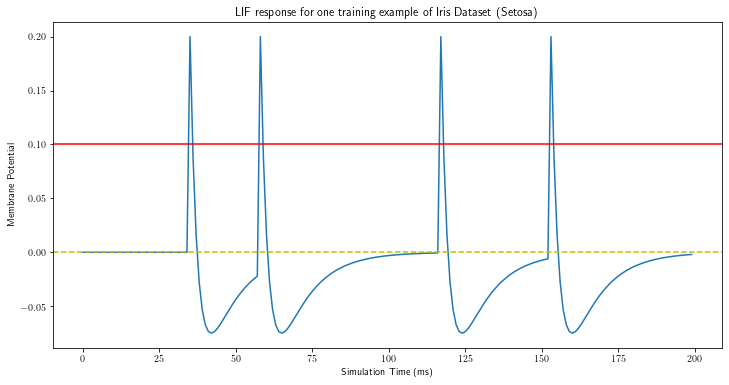

In [1074]:
# Graph of SNN 
plt.rcParams["figure.figsize"] =(12,6)
## Draw input spikes
#plt.figure()
#plt.axis([0, T, 0, spike_trains.n_syn])
#plt.title('Synaptic spikes')
#plt.ylabel('synapses')
#plt.xlabel('Time (msec)')
#t, spikes = spike_trains.get_spikes()
#plt.scatter(t, spikes, s=2)
# Draw membrane potential
plt.figure()
plt.plot(*zip(*P))
plt.axhline(y=neuron.T, color='r', linestyle='-')
plt.axhline(y=neuron.p_rest, color='y', linestyle='--')
plt.title('LIF response for one training example of Iris Dataset (Setosa)')
plt.ylabel('Membrane Potential')
plt.xlabel('Simulation Time (ms)')
plt.savefig('Project/Images/iris_snn_3.png')
plt.show()

## Evolutionary Algorithms for Training SNN

### Algorithm - 1 : Real Coded Genetic Algorithm 

### Fitness Function

In [928]:
def fitness_function(desired_class,population):
    err = []
    s = []
    spike_count_list = []
    acc_list = []
    acc = []
    
    for i in range(0,len(population)):
        spike_count_list.append(snn(population[i]))
        spike_count_list[i] = np.array(spike_count_list[i])
        spike_count_list[i][((spike_count_list[i]>=0) & (spike_count_list[i]<=10))] = 1
        spike_count_list[i][((spike_count_list[i]>10) & (spike_count_list[i]<=20))] = 2
        spike_count_list[i][(spike_count_list[i]>20)] = 3
    for i in range(0,len(spike_count_list)):
        for j in range(0,len(spike_count_list[i])):
            s.append(spike_count_list[i][j] - desired_class[j])
        l = s.count(0)
        err.append(l/len(desired_class)) 
        s = []
        acc.append((err[i])*100)
    return(acc)

In [ ]:
population = []
start_time = time.time()
for i in range(0,20):
    s = np.float32(np.random.uniform(low=-1,high=1,size=4))
    population.append(s)

f = fitness_function(np.array(df['class'][0:30]),population)
print((time.time()-start_time))

In [ ]:
def crossover(p1,p2):
    h1 = 0.5*p1 + 0.5*p2
    h2 = 1.5*p1 - 0.5*p2
    h3 = 1.5*p2 - 0.5*p1
    return(h1,h2,h3)

In [932]:
def mutation(solution,max_solution,min_solution,current_gen,max_gen):
    rand = np.random.uniform(0,1)
    if(rand<=0.5):
        tau = 1
    else:
        tau = -1
    b = 1
    d = math.pow((1 - (current_gen/max_gen)),b)
    new_solution = solution + tau*(max_solution - min_solution)*(1-math.pow(rand,d))
    return(new_solution)

In [933]:
def genetic_algorithm(population,desired_times,num_epochs):
    
    max_fitness_copy = []
    mean_fitness_copy = []
    
    fitness = fitness_function(desired_times,population)
    fitness_copy = fitness
    
    for epochs in range(0,num_epochs):
    # Compute Fitness Value of entire population and store it in a list
    
        indexes = np.argsort(-np.array(fitness))
        fitness = -np.sort(-np.array(fitness))

        index = indexes[0:2]

        # Compare fitness values of population and pick best 2 parents

        parent_1 = population[index[0]]
        parent_2 = population[index[1]]

        # Do crossover to get 3 children 

        child_1,child_2,child_3 = crossover(parent_1,parent_2)
        

        # Decide whether to add them to population based on their fitness

        children = []
        children.extend([child_1,child_2,child_3])
        
        best_solution = population[indexes[0]]
        worst_solution = population[indexes[len(indexes)-1]]
        
        for i in range(0,len(children)):
            children[i] = mutation(children[i],best_solution,worst_solution,epochs+1,num_epochs)
            children[i][children[i]>2] = 2
            children[i][children[i]<-2] = -2
            
        population.append(child_1)
        population.append(child_2)
        population.append(child_3)
        
        fitness_copy.extend(fitness_function(desired_times,children))
        
        index = np.argsort(-np.array(fitness_copy))
        fitness_copy = -np.sort(-np.array(fitness_copy))
        
        index_remove = index[len(index)-4:len(index)-1]
        fitness_copy = [i for j, i in enumerate(fitness_copy) if j not in index_remove]
        population = [i for j, i in enumerate(population) if j not in index_remove]

        print(epochs+1)
        max_fitness_copy.append(max(fitness_copy))
        mean_fitness_copy.append(statistics.mean(fitness_copy))
        
        max_fitness_array = np.array(max_fitness_copy)
        mean_fitness_array = np.array(mean_fitness_copy)
        
        population_array = np.array(population)
        
        np.save('max_fitness_array',max_fitness_array)
        np.save('mean_fitness_array',mean_fitness_array)
        np.save('population_array',population_array)
        
        fitness = fitness_function(desired_times,population)
        
    return(fitness,population,max_fitness_copy,mean_fitness_copy)
    
    # End GA

In [ ]:
population = []
for i in range(0,20):
    s = np.float32(np.random.uniform(low=-1,high=1,size=4))
    population.append(s)
print(len(population))
fit,weights,max_fit,mean_fit = genetic_algorithm(population,np.array(df['class'][0:30]),20)

In [ ]:
print(fit)

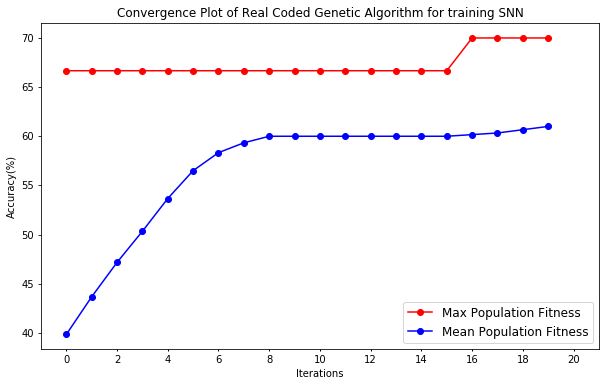

In [937]:
# Plots for Genetic Algorithm
plt.rcParams["figure.figsize"] =(10,6)
plt.title('Convergence Plot of Real Coded Genetic Algorithm for training SNN')
plt.ylabel('Accuracy(%)')
plt.xlabel('Iterations')
x1 = np.arange(20)
y1 = max_fit
plt.plot(x1,y1,'-bo',color='red',label='Max Population Fitness')
plt.xlim(-1,21)
x2 = np.arange(20)
y2 = mean_fit
plt.plot(x2,y2,'-bo',color='blue',label='Mean Population Fitness')
plt.xticks(np.arange(0, 21, 2.0))
plt.tick_params(axis='x',length=2, width=1)
plt.legend(prop={'size': 12})
plt.savefig('Project/Images/rgca_snn_1.png')
plt.show()

### Algorithm - 2 : Differential Evolution

In [977]:
def diff_evol(desired_class,population,min_val,max_val,mut,crossp,num_epochs):
    
    fitness = fitness_function(desired_class,population)
    fitness_copy_de = np.array(fitness)

    mean_fitness = np.zeros(num_epochs)
    max_fitness = np.zeros(num_epochs)
    
    for epochs in range(0,num_epochs):
        
        mean_fitness[epochs] = np.mean(fitness_copy_de)
        max_fitness[epochs] = np.max(fitness_copy_de)
        
        print(mean_fitness[epochs])
        print(max_fitness[epochs])
        
        np.save('max_fitness_array_de',max_fitness)
        np.save('mean_fitness_array_de',mean_fitness)
        np.save('population_array_de',population)
        
        for i in range(0,len(population)):
            index = [index for index in range(len(population)) if index != i]
            a,b,c = population[np.random.choice(index,3,replace=False)] #Remember to initialise population as an np array
            
            new_solution = np.clip(a + mut*(b-c),min_val,max_val)
            cross_points = np.random.rand(len(population[i])) < crossp
            if not np.any(cross_points): # Just ensuring recombination is happening
                cross_points[np.random.randint(0, dimensions)] = True
            
            trial = np.where(cross_points, new_solution, population[i])
            
            fitness_trial = fitness_function(desired_class,[trial])
            
            if(fitness_trial > fitness_copy_de[i]):
                fitness_copy_de[i] = np.copy(fitness_trial)
                population[i] = np.copy(trial)
                print(True)
                
        print(epochs+1) 
    return(fitness_copy_de,population,mean_fitness,max_fitness)

In [ ]:
start_time = time.time()
population = []
for i in range(0,20):
    s = np.float32(np.random.uniform(low=-1,high=1,size=4))
    population.append(s)
f1 = fitness_function(np.array(df['class'][0:30]),population)
population = np.array(population)
print(f1)
fit_de,weights_de,mean_de,max_de = diff_evol(np.array(df['class'][0:30]),population,-2,2,0.8,0.7,20)

In [ ]:
print(fit_de)
max_de = np.load('max_fitness_array_de.npy')
mean_de = np.load('mean_fitness_array_de.npy')

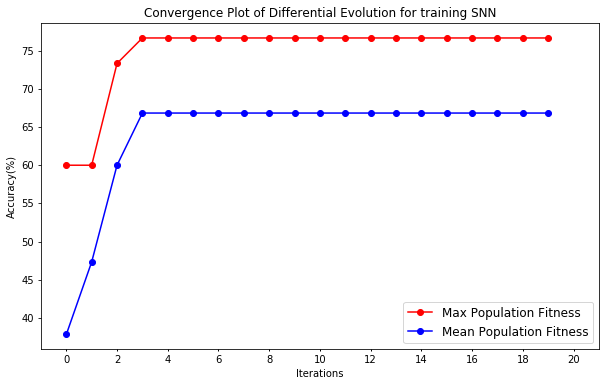

In [981]:
# Plots for Differential Evolution
plt.rcParams["figure.figsize"] =(10,6)
plt.title('Convergence Plot of Differential Evolution for training SNN')
plt.ylabel('Accuracy(%)')
plt.xlabel('Iterations')
x1 = np.arange(20)
y1 = max_de
plt.plot(x1,y1,'-bo',color='red',label='Max Population Fitness')
plt.xlim(-1,21)
x2 = np.arange(20)
y2 = mean_de
plt.plot(x2,y2,'-bo',color='blue',label='Mean Population Fitness')
plt.xticks(np.arange(0, 21, 2.0))
plt.tick_params(axis='x',length=2, width=1)
plt.legend(prop={'size': 12})
plt.savefig('Project/Images/de_snn_1.png')
plt.show()

### Algorithm - 3 :  Particle Swarm Optimization 

In [1067]:
def pso(desired_class,position,velocity,min_val,max_val,num_epochs):
    
    fitness = fitness_function(desired_class,list(position))
    fitness_copy_pso = np.array(fitness)
    
    particle_best = position

    c1 = 1
    c2 = 1
    r1 = np.random.uniform(0,1)
    r2 = np.random.uniform(0,1)
    w = 0.5
    
    mean_fitness = np.zeros(num_epochs)
    max_fitness = np.zeros(num_epochs)
        
    for epochs in range(0,num_epochs):
        
        mean_fitness[epochs] = np.mean(fitness_copy_pso)
        print(mean_fitness[epochs])
        
        np.save('max_fitness_array_pso',max_fitness)
        np.save('mean_fitness_array_pso',mean_fitness)
        np.save('population_array_pso',population)
        
        for i in range(0,len(fitness_copy_pso)): # Set best particle fitness value
            fitness_pbest = fitness_function(desired_class,[particle_best[i]])
            if(fitness_pbest<fitness_copy_pso[i]):
                particle_best[i] = np.copy(position[i])
        
        index = np.argmax(fitness_copy_pso)
        global_best = position[index]
        max_fitness[epochs] = fitness_copy_pso[index]
        print(max_fitness[epochs])
        
        for i in range(0,len(position)):
            for j in range(0,len(position[i])):
                velocity[i][j] = w*velocity[i][j] + c1*r1*(particle_best[i][j]-position[i][j])
                +c2*r2*(global_best[j]-position[i][j])
        
            velocity[velocity<0] = 0
            velocity[velocity>2] = 2
        
            position[i] = position[i] + velocity[i]
    
        position[position>2] = 2
        position[position<-2] = -2
        
        fitness_copy_pso = np.array(fitness_function(desired_class,list(position)))
        
        print(epochs)
        
    return(position,fitness_copy_pso,mean_fitness,max_fitness)

In [ ]:
position = np.float32(np.random.uniform(-1,1,size = (10,4)))
velocity = np.float32(np.random.uniform(0,1,size = (10,4)))

print(len(position))
p,f,mean_pso,max_pso = pso(np.array(df['class'][0:30]),position,velocity,-2,2,20)

In [ ]:
print(f)

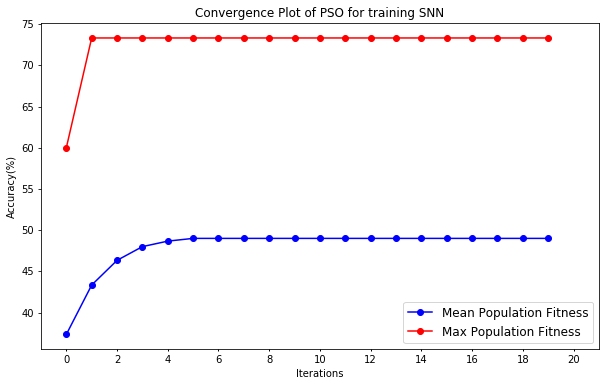

In [971]:
# Plots for PSO
plt.rcParams["figure.figsize"] =(10,6)
plt.title('Convergence Plot of PSO for training SNN')
plt.ylabel('Accuracy(%)')
plt.xlabel('Iterations')
x1 = np.arange(20)
y1 = mean_pso
plt.plot(x1,y1,'-bo',color='blue',label='Mean Population Fitness')
plt.xlim(-1,21)
x2 = np.arange(20)
y2 = max_pso
plt.plot(x2,y2,'-bo',color='red',label='Max Population Fitness')
plt.xticks(np.arange(0, 21, 2.0))
plt.tick_params(axis='x',length=2, width=1)
plt.legend(prop={'size': 12})
plt.savefig('Project/Images/pso_snn_1.png')
plt.show()

### Ensemble using all 3 methods

In [983]:
w1 = np.load('population_array.npy')
w2 = np.load('population_array_de.npy')
w3 = np.load('population_array_pso.npy')

In [ ]:
s1 = snn(weights[np.argmax(fit)])
s1 = np.array(s1)
print(s)
s1[((s1>=0) & (s1<=10))] = 1
s1[((s1>10) & (s1<=20))] = 2
s1[(s1>20)] = 3

err = s1 - np.array(df['class'][0:30])
print(err)
print(len(err) - np.count_nonzero(err))

s2 = snn(w2[np.argmax(fit_de)])
s2 = np.array(s2)
print(s)
s2[((s2>=0) & (s2<=10))] = 1
s2[((s2>10) & (s2<=20))] = 2
s2[(s2>20)] = 3

err = s2 - np.array(df['class'][0:30])
print(err)
print(len(err) - np.count_nonzero(err))

In [ ]:
s3 = snn(p[5])
s3 = np.array(s3)
print(s)
s3[((s3>=0) & (s3<=10))] = 1
s3[((s3>10) & (s3<=20))] = 2
s3[(s3>20)] = 3

err = s3 - np.array(df['class'][0:30])
print(err)
len(err) - np.count_nonzero(err)

In [ ]:
# Voting by averaging the weights
w_avg = (weights[np.argmax(fit)]+ p[5])/2
s = snn(w_avg)
s = np.array(s)
print(s)
s[((s>=0) & (s<=10))] = 1
s[((s>10) & (s<=20))] = 2
s[(s>20)] = 3

err = s - np.array(df['class'][0:30])
print(err)
len(err) - np.count_nonzero(err)

In [1065]:
# Majority Voting
final_result = np.vstack([s1,s3])
print(final_result)
m = stats.mode(final_result)

print(m[0],"Final Classification")

err = m[0]- np.array(df['class'][0:30])
print(err)

[[2 2 2 1 2 2 1 1 3 2 3 1 2 3 2 3 1 2 1 1 2 2 3 3 3 1 1 1 1 2]
 [3 2 3 1 2 2 1 1 3 2 3 1 2 3 2 3 1 2 1 1 2 2 3 3 3 1 1 1 2 2]]
[[2 2 2 1 2 2 1 1 3 2 3 1 2 3 2 3 1 2 1 1 2 2 3 3 3 1 1 1 1 2]] Final Classification
[[-1  0 -1  0 -1  0  0  0  0  0  1  0  0  0  0  0  0 -1  0 -1 -1  1  0  0
   0 -1  0  0  0  0]]
